In [4]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
valid_size = .05
batch_size = 16
num_workers = 2

gaussianChoices = [transforms.GaussianBlur(kernel_size = 1, sigma = (.001, 5)),
                  transforms.GaussianBlur(kernel_size = 3, sigma = (.001, 5)),
                  transforms.GaussianBlur(kernel_size = 5, sigma = (.001, 5)),
                  transforms.GaussianBlur(kernel_size = 7, sigma = (.001, 5))]

train_transform = transforms.Compose([transforms.Resize(128),
                                      transforms.RandomChoice(gaussianChoices),
                                    transforms.ToTensor()])

categories = os.listdir("./progan_train")
train_datasets = []
print("Loading Training Data...", flush=True)
for category in tqdm(categories):
    train_datasets.append(datasets.ImageFolder("./progan_train/" + category, transform = train_transform))
    
train_dataset = torch.utils.data.ConcatDataset(train_datasets)

test_transform = transforms.Compose([transforms.Resize(128),
                                    transforms.ToTensor()])

#train_dataset = datasets.ImageFolder("./progan_train/horse/", transform=train_transform)

print("Loading Testing Data...", flush=True)
test_datasets = []
for category in tqdm(categories):
    test_datasets.append(datasets.ImageFolder("./CNN_synth_testset/progan/" + category, transform=test_transform))
    
test_dataset = torch.utils.data.ConcatDataset(test_datasets)

num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
                                               num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

class_names = train_datasets[0].classes


Loading Training Data...


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]

Loading Testing Data...



100%|██████████| 20/20 [00:00<00:00, 543.69it/s]


In [3]:
torch.save(train_loader, "./M-Gb/train_loader.pt")
torch.save(valid_loader, "./M-Gb/valid_loader.pt")
torch.save(test_loader, "./M-Gb/test_loader.pt")

In [5]:
train_loader = torch.load("./M-Gb/train_loader.pt")
valid_loader = torch.load("./M-Gb/valid_loader.pt")
test_loader = torch.load("./M-Gb/test_loader.pt")
len(train_loader), len(valid_loader), len(test_loader)

(42758, 2251, 500)

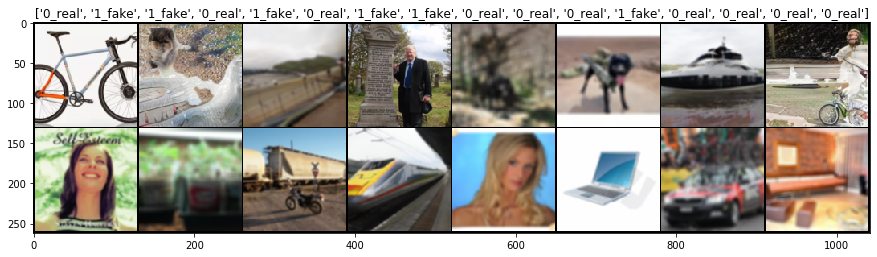

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure(figsize=(15,15))
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
class MGib(nn.Module):
    def __init__(self):
        super(MGib, self).__init__()
        ####################  
        self.conv1 = nn.Conv2d(3, 128, 4, 2, padding = 1)
        self.conv2 = nn.Conv2d(128, 256, 4, 2, padding = 1)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 512, 4, 2, padding = 1)
        self.bn2 = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512, 1024, 4, 2, padding = 1)
        self.bn3 = nn.BatchNorm2d(1024)
        self.fc = nn.Linear(1024 * 8 * 8, 2)

    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x = F.relu(x)
        x = self.conv2(x)
        #print(x.shape)
        x = F.relu(x)
        x = self.bn1(x)
        #print(x.shape)
        x = self.conv3(x)
        #print(x.shape)
        x = F.relu(x)
        x = self.bn2(x)
        #print(x.shape)
        x = self.conv4(x)
        x = F.relu(x)
        #print(x.shape)
        x = self.bn3(x)
        #print(x.shape)
        x = x.view(-1, 65536)
        #print(x.shape)
        x = self.fc(x)
        #print(x.shape)
        return x

model = MGib()
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
print(model)
print('{:,}'.format(sum(p.numel() for p in model.parameters())))

MGib(
  (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=65536, out_features=2, bias=True)
)
11,152,770


In [31]:
num_epochs = 5
since = time.time()
print_every_n_batches = 2000
losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % print_every_n_batches == print_every_n_batches - 1:
            #Calculate validation loss
            n = 0
            acc = torch.tensor(0).to(device)
            for data in valid_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                y_pred = torch.argmax(model(inputs), 1) 
                acc = torch.add(acc, torch.sum(y_pred == labels))
                n += len(labels)

            val_acc = acc / float(n)
            print('[%d, %5d] training loss: %.3f val acc: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every_n_batches, val_acc), end = " ")
            val_accs.append(val_acc)
            losses.append(running_loss / print_every_n_batches)
            running_loss = 0.0
            
            time_elapsed = time.time() - since
            print(f'Time elapsed: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    torch.save(model, "./M-Gb/model" + str(epoch) + ".pt")
        
time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

Epoch 1/5
----------
[1,  2000] training loss: 3.222 val acc: 0.501 Time elapsed: 6m 25s
[1,  4000] training loss: 0.748 val acc: 0.501 Time elapsed: 11m 35s
[1,  6000] training loss: 0.698 val acc: 0.500 Time elapsed: 16m 50s
[1,  8000] training loss: 0.695 val acc: 0.500 Time elapsed: 21m 37s
[1, 10000] training loss: 0.703 val acc: 0.497 Time elapsed: 26m 15s
[1, 12000] training loss: 0.706 val acc: 0.503 Time elapsed: 30m 35s
[1, 14000] training loss: 0.703 val acc: 0.502 Time elapsed: 34m 46s
[1, 16000] training loss: 0.709 val acc: 0.500 Time elapsed: 38m 56s
[1, 18000] training loss: 0.703 val acc: 0.503 Time elapsed: 42m 46s
[1, 20000] training loss: 0.702 val acc: 0.501 Time elapsed: 47m 50s
[1, 22000] training loss: 0.701 val acc: 0.500 Time elapsed: 51m 24s
[1, 24000] training loss: 0.702 val acc: 0.502 Time elapsed: 54m 49s
[1, 26000] training loss: 0.702 val acc: 0.513 Time elapsed: 58m 1s
[1, 28000] training loss: 0.697 val acc: 0.509 Time elapsed: 61m 21s
[1, 30000] trai

In [37]:
num_epochs = 8
since = time.time()
print_every_n_batches = 2000
#losses = []
#val_accs = []
for epoch in range(5, num_epochs):
    running_loss = 0.0
    
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % print_every_n_batches == print_every_n_batches - 1:
            #Calculate validation loss
            n = 0
            acc = torch.tensor(0).to(device)
            for data in valid_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                y_pred = torch.argmax(model(inputs), 1) 
                acc = torch.add(acc, torch.sum(y_pred == labels))
                n += len(labels)

            val_acc = acc / float(n)
            print('[%d, %5d] training loss: %.3f val acc: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every_n_batches, val_acc), end = " ")
            val_accs.append(val_acc)
            losses.append(running_loss / print_every_n_batches)
            running_loss = 0.0
            
            time_elapsed = time.time() - since
            print(f'Time elapsed: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    torch.save(model, "./M-Gb/model" + str(epoch) + ".pt")
        
time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

Epoch 6/8
----------
[6,  2000] training loss: 0.444 val acc: 0.789 Time elapsed: 3m 9s
[6,  4000] training loss: 0.433 val acc: 0.767 Time elapsed: 6m 17s
[6,  6000] training loss: 0.452 val acc: 0.751 Time elapsed: 9m 30s
[6,  8000] training loss: 0.438 val acc: 0.789 Time elapsed: 12m 42s
[6, 10000] training loss: 0.431 val acc: 0.793 Time elapsed: 15m 53s
[6, 12000] training loss: 0.430 val acc: 0.800 Time elapsed: 19m 2s
[6, 14000] training loss: 0.427 val acc: 0.773 Time elapsed: 22m 11s
[6, 16000] training loss: 0.437 val acc: 0.808 Time elapsed: 25m 20s
[6, 18000] training loss: 0.426 val acc: 0.795 Time elapsed: 28m 29s
[6, 20000] training loss: 0.441 val acc: 0.799 Time elapsed: 31m 40s
[6, 22000] training loss: 0.415 val acc: 0.811 Time elapsed: 34m 50s
[6, 24000] training loss: 0.437 val acc: 0.782 Time elapsed: 38m 1s
[6, 26000] training loss: 0.578 val acc: 0.707 Time elapsed: 41m 10s
[6, 28000] training loss: 0.506 val acc: 0.792 Time elapsed: 44m 41s
[6, 30000] training

In [41]:
for g in optimizer.param_groups:
    g['lr'] = 0.0001

In [42]:
num_epochs = 10
since = time.time()
print_every_n_batches = 2000
#losses = []
#val_accs = []
for epoch in range(8, num_epochs):
    running_loss = 0.0
    
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % print_every_n_batches == print_every_n_batches - 1:
            #Calculate validation loss
            n = 0
            acc = torch.tensor(0).to(device)
            for data in valid_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                y_pred = torch.argmax(model(inputs), 1) 
                acc = torch.add(acc, torch.sum(y_pred == labels))
                n += len(labels)

            val_acc = acc / float(n)
            print('[%d, %5d] training loss: %.3f val acc: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every_n_batches, val_acc), end = " ")
            val_accs.append(val_acc)
            losses.append(running_loss / print_every_n_batches)
            running_loss = 0.0
            
            time_elapsed = time.time() - since
            print(f'Time elapsed: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    torch.save(model, "./M-Gb/model" + str(epoch) + ".pt")
        
time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

Epoch 9/10
----------
[9,  2000] training loss: 0.278 val acc: 0.878 Time elapsed: 3m 22s
[9,  4000] training loss: 0.270 val acc: 0.878 Time elapsed: 6m 39s
[9,  6000] training loss: 0.261 val acc: 0.886 Time elapsed: 9m 54s
[9,  8000] training loss: 0.256 val acc: 0.886 Time elapsed: 13m 10s
[9, 10000] training loss: 0.256 val acc: 0.889 Time elapsed: 16m 27s
[9, 12000] training loss: 0.254 val acc: 0.890 Time elapsed: 19m 42s
[9, 14000] training loss: 0.250 val acc: 0.891 Time elapsed: 22m 58s
[9, 16000] training loss: 0.247 val acc: 0.890 Time elapsed: 26m 16s
[9, 18000] training loss: 0.242 val acc: 0.891 Time elapsed: 29m 33s
[9, 20000] training loss: 0.240 val acc: 0.893 Time elapsed: 32m 50s
[9, 22000] training loss: 0.249 val acc: 0.895 Time elapsed: 36m 7s
[9, 24000] training loss: 0.240 val acc: 0.895 Time elapsed: 39m 23s
[9, 26000] training loss: 0.235 val acc: 0.894 Time elapsed: 42m 40s
[9, 28000] training loss: 0.232 val acc: 0.894 Time elapsed: 45m 58s
[9, 30000] train

In [43]:
torch.save(model, "./M-Gb/paranoid_save.pt")

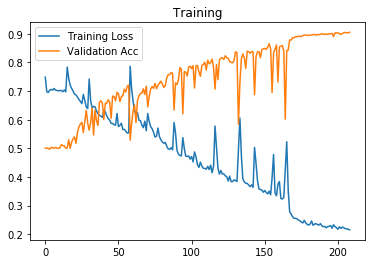

In [44]:
plt.title("Training")
plt.plot(losses[1:], label="Training Loss")
plt.plot(val_accs[1:], label="Validation Acc")
plt.legend()

In [8]:
model = torch.load("./M-Gb/paranoid_save.pt")

In [9]:
n = 0
acc = torch.tensor(0).to(device)
for data in test_loader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    y_pred = torch.argmax(model.forward(inputs), 1) 
    acc = torch.add(acc, torch.sum(y_pred == labels))
    n += len(labels)
    
acc / float(n)

tensor(0.9186, device='cuda:0')

In [12]:
batch_size = 16
num_workers = 2
gans = os.listdir("./CNN_synth_testset")
test_accs = []
gans.remove("progan")
gan_transform = transforms.Compose([transforms.Resize((128,128)),
                                    transforms.ToTensor()])
for gan in tqdm(gans):
    subdirs = os.listdir("./CNN_synth_testset/" + gan)
    if len(subdirs) == 2:
        gan_dataset = datasets.ImageFolder("./CNN_synth_testset/" + gan, transform=gan_transform)
    else:
        gan_datasets = [datasets.ImageFolder("./CNN_synth_testset/" + gan + "/" + cat, transform=gan_transform) for cat in subdirs]
        gan_dataset = torch.utils.data.ConcatDataset(gan_datasets)
        
    gan_loader = torch.utils.data.DataLoader(gan_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
        
    n = 0
    acc = torch.tensor(0).to(device)
    for data in gan_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        y_pred = torch.argmax(model(inputs), 1)
        acc = torch.add(acc, torch.sum(y_pred == labels))
        n += len(labels)
    
    test_accs.append(acc / float(n))

100%|██████████| 12/12 [06:08<00:00, 30.74s/it]


<BarContainer object of 12 artists>

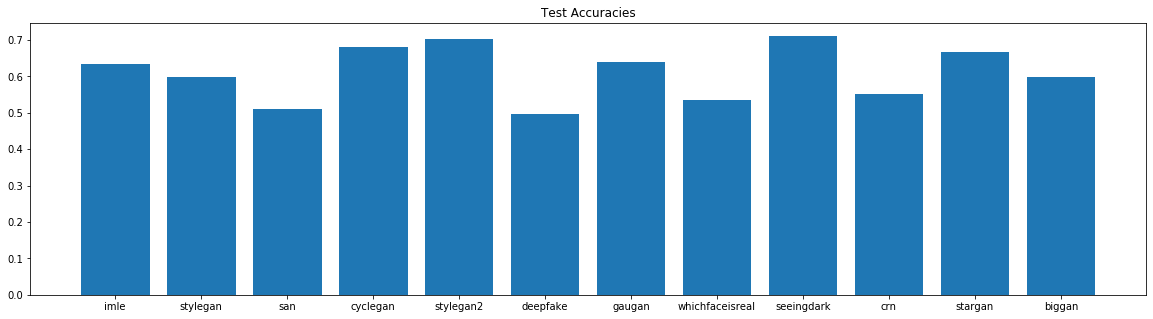

In [13]:
plt.figure(figsize=(20,5))
plt.title("Test Accuracies")
plt.bar(gans, test_accs)

In [14]:
import pickle
with open("./M-Gb/test_accs.txt", "wb") as file:
    pickle.dump(test_accs, file)

In [15]:
import pickle
with open("./M-Gb/test_accs.txt", "rb") as file:
    test_accs = pickle.load(file)

test_accs

[tensor(0.6351, device='cuda:0'),
 tensor(0.5994, device='cuda:0'),
 tensor(0.5114, device='cuda:0'),
 tensor(0.6805, device='cuda:0'),
 tensor(0.7024, device='cuda:0'),
 tensor(0.4966, device='cuda:0'),
 tensor(0.6408, device='cuda:0'),
 tensor(0.5365, device='cuda:0'),
 tensor(0.7111, device='cuda:0'),
 tensor(0.5525, device='cuda:0'),
 tensor(0.6661, device='cuda:0'),
 tensor(0.5995, device='cuda:0')]